# Stock trend prediction with Machine Learning (random forests)
This is not investment advice.

This notebook is based on blog post from quantisti.com https://blog.quantinsti.com/decision-tree/.

The article was trying to predict stock price one day ahead using decision tree algorithm and stock technical indicators.

Here we will expand on that aticle by:

getting data from Yahoo! Finance API
using scikit random forest algorithm
not predicting price one day ahead, but predicting uptrend many days ahead
using these technical indicators - Paraboloc SAR, RSI, Bollinger Bands and series of Exponencial Moving Averages
algorithm will be giving only buy signals
using incremental training of the model from multiple stock data
model saving and loading will be done using joblib library
My tests are showing that predicting price ahead give very noisy results (at least with random forests). But alteranative approach is giving very nice predictive results.

So the question is: can random forests predict stock trend tens of days ahead with reasonable accuracy?

Pretty much YES, really looks like the trend predictions do not give as many noisy data as we would expect.

Also as we will see in the final prediction, the random forest is advising to be buying for the whole duration of an uptrend as long as it thinks the uptrend will be continuing. So the model will not give us buy signal at one specific

Note:
Also it looks like an interesting idea to do something similar using XGBoost algorithm as described on this Kaggle kernel: https://www.kaggle.com/mtszkw/using-xgboost-for-stock-trend-prices-prediction

Note: Normalized volume has not been used, but might be interesting predictor to use.

In [ ]:
!pip install talib-binary
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import talib as ta
import yfinance as yf
import joblib

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

# ML related imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
# --- additional setup ---
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#suppress 'SettingWithCopy' warning
pd.set_option('mode.chained_assignment', None)

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

# colab/jupyter setup
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

### Var definitions

In [ ]:
start_time = datetime.datetime(1980, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

## Function definitions

In [ ]:
def get_data(ticker):
    # yahoo API
    connected = False
    while not connected:
        try:
            df = yf.download(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   

    # use numerical integer index instead of date    
    df = df.reset_index()
    #print(df.head(5))
    return df

In [ ]:
def compute_technical_indicators(df):
    df['EMA5'] = ta.EMA(df['Adj Close'].values, timeperiod=5)
    df['EMA10'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    df['EMA15'] = ta.EMA(df['Adj Close'].values, timeperiod=15)
    df['EMA20'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    df['EMA30'] = ta.EMA(df['Adj Close'].values, timeperiod=30)
    df['EMA40'] = ta.EMA(df['Adj Close'].values, timeperiod=40)
    df['EMA50'] = ta.EMA(df['Adj Close'].values, timeperiod=50)

    df['EMA60'] = ta.EMA(df['Adj Close'].values, timeperiod=60)
    df['EMA70'] = ta.EMA(df['Adj Close'].values, timeperiod=70)
    df['EMA80'] = ta.EMA(df['Adj Close'].values, timeperiod=80)
    df['EMA90'] = ta.EMA(df['Adj Close'].values, timeperiod=90)
    
    df['EMA100'] = ta.EMA(df['Adj Close'].values, timeperiod=100)
    df['EMA150'] = ta.EMA(df['Adj Close'].values, timeperiod=150)
    df['EMA200'] = ta.EMA(df['Adj Close'].values, timeperiod=200)

    df['upperBB'], df['middleBB'], df['lowerBB'] = ta.BBANDS(df['Adj Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['SAR'] = ta.SAR(df['High'].values, df['Low'].values, acceleration=0.02, maximum=0.2)
    df['RSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14)

    df.tail()

    return df

In [ ]:
def compute_features(df):
    # computes features for forest decisions
    df['aboveEMA5'] = np.where(df['Adj Close'] > df['EMA5'], 1, -1)
    df['aboveEMA10'] = np.where(df['Adj Close'] > df['EMA10'], 1, -1)
    df['aboveEMA15'] = np.where(df['Adj Close'] > df['EMA15'], 1, -1)
    df['aboveEMA20'] = np.where(df['Adj Close'] > df['EMA20'], 1, -1)
    df['aboveEMA30'] = np.where(df['Adj Close'] > df['EMA30'], 1, -1)
    df['aboveEMA40'] = np.where(df['Adj Close'] > df['EMA40'], 1, -1)
    
    df['aboveEMA50'] = np.where(df['Adj Close'] > df['EMA50'], 1, -1)
    df['aboveEMA60'] = np.where(df['Adj Close'] > df['EMA60'], 1, -1)
    df['aboveEMA70'] = np.where(df['Adj Close'] > df['EMA70'], 1, -1)
    df['aboveEMA80'] = np.where(df['Adj Close'] > df['EMA80'], 1, -1)
    df['aboveEMA90'] = np.where(df['Adj Close'] > df['EMA90'], 1, -1)
    
    df['aboveEMA100'] = np.where(df['Adj Close'] > df['EMA100'], 1, -1)
    df['aboveEMA150'] = np.where(df['Adj Close'] > df['EMA150'], 1, -1)
    df['aboveEMA200'] = np.where(df['Adj Close'] > df['EMA200'], 1, -1)

    df['aboveUpperBB'] = np.where(df['Adj Close'] > df['upperBB'], 1, -1)
    df['belowLowerBB'] = np.where(df['Adj Close'] < df['lowerBB'], 1, -1)
    
    df['aboveSAR'] = np.where(df['Adj Close'] > df['SAR'], 1, -1)
   
    df['oversoldRSI'] = np.where(df['RSI'] < 30, 1, -1)
    df['overboughtRSI'] = np.where(df['RSI'] > 70, 1, -1)


    # very important - cleanup NaN values, otherwise prediction does not work
    df=df.fillna(0).copy()
    
    #df.tail()

    return df

In [ ]:
def plot_train_data(df):
    # plot price
    plt.figure(figsize=(15,2.5))
    plt.title('Stock data ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'])
    #plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()
    return None

## Target condition - criterion

In [ ]:
def define_target_condition(df):
 
    # price higher later - bad predictive results
    #df['target_cls'] = np.where(df['Adj Close'].shift(-34) > df['Adj Close'], 1, 0)    
    
    # price above trend multiple days later
    df['target_cls'] = np.where(df['Adj Close'].shift(-55) > df.EMA150.shift(-55), 1, 0)

    # important, remove NaN values
    df=df.fillna(0).copy()
    
    df.tail()
    
    return df

## Function definitions: Train-Test split and model training part
You can set the 'warm_start' parameter to True in the model. This will ensure the retention of learned parameters from previous round using .fit method. Convenient for continuous training on streamed data.

In [ ]:
def splitting_and_training(df):
    # __predictors__
    predictors_list = ['aboveSAR','aboveUpperBB','belowLowerBB','RSI','oversoldRSI','overboughtRSI',
                       'aboveEMA5','aboveEMA10','aboveEMA15','aboveEMA20','aboveEMA30','aboveEMA40','aboveEMA50',
                       'aboveEMA60','aboveEMA70','aboveEMA80','aboveEMA90',
                       'aboveEMA100']
    
    # __features__
    X = df[predictors_list].fillna(0)
    #print('X.tail', X.tail())
    X = X.to_numpy()
    #print('X', X)

    # __targets__
    y_cls = df.target_cls.fillna(0)
    #print('y_cls.tail', y_cls.tail(10))
    y_cls = y_cls.to_numpy()
    #print('y_cls', y_cls)

    # __train test split__
    #from sklearn.model_selection import train_test_split
    y=y_cls
    X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=0.3, random_state=432, stratify=y)

    #print (X_cls_train.shape, y_cls_train.shape)
    #print (X_cls_test.shape, y_cls_test.shape)

    # __RANDOM FOREST __       - retrainable - warm_start
    #from sklearn.ensemble import RandomForestClassifier

    #Create a Gaussian Classifier - incremental training - warm_start=True
    clf=RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=20, min_samples_leaf=10, 
                               n_jobs=-1, warm_start=True)

    # __ACTUAL TRAINING __
    clf = clf.fit(X_cls_train, y_cls_train)
    #clf

    # __making accuracy report__
    # ideally should be getting better with each round
    y_cls_pred = clf.predict(X_cls_test)

    #from sklearn.metrics import classification_report
    report = classification_report(y_cls_test, y_cls_pred)
    #print(report)

    return clf

In [ ]:
def predict_timeseries(df, clf):
    
    # making sure we have good dimensions
    # column will be rewritten later
    df['Buy'] = df['target_cls']
    
    for i in range(len(df)):
        X_cls_valid = [[df['aboveSAR'][i],df['aboveUpperBB'][i],df['belowLowerBB'][i],
                        df['RSI'][i],df['oversoldRSI'][i],df['overboughtRSI'][i],
                        df['aboveEMA5'][i],df['aboveEMA10'][i],df['aboveEMA15'][i],df['aboveEMA20'][i],
                        df['aboveEMA30'][i],df['aboveEMA40'][i],df['aboveEMA50'][i],
                        df['aboveEMA60'][i],df['aboveEMA70'][i],df['aboveEMA80'][i],df['aboveEMA90'][i],
                        df['aboveEMA100'][i]]]    

        y_cls_pred_valid = clf.predict(X_cls_valid)
        df['Buy'][i] = y_cls_pred_valid[0].copy()

    print(df.head())    
        
    return df

In [ ]:
def plot_stock_prediction(df, ticker):
    # plot  values and significant levels
    plt.figure(figsize=(20,7))
    plt.title('Predictive model ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='High', alpha=0.2)

    plt.plot(df['Date'], df['EMA10'], label='EMA10', alpha=0.2)
    plt.plot(df['Date'], df['EMA20'], label='EMA20', alpha=0.2)
    plt.plot(df['Date'], df['EMA30'], label='EMA30', alpha=0.2)
    plt.plot(df['Date'], df['EMA40'], label='EMA40', alpha=0.2)
    plt.plot(df['Date'], df['EMA50'], label='EMA50', alpha=0.2)
    plt.plot(df['Date'], df['EMA100'], label='EMA100', alpha=0.2)
    plt.plot(df['Date'], df['EMA150'], label='EMA150', alpha=0.99)
    plt.plot(df['Date'], df['EMA200'], label='EMA200', alpha=0.2)

    plt.scatter(df['Date'], df['Buy']*df['Adj Close'], label='Buy', marker='^', color='magenta', alpha=0.15)
    #lt.scatter(df.index, df['sell_sig'], label='Sell', marker='v')

    plt.legend()

    plt.show()

    return None   

In [ ]:
def save_model(clf):
    joblib.dump(clf, "./random_forest.joblib")
    return None

## Training sequence

In [ ]:
# training stock data
tickers = ['SPY', 'F', 'IBM', 'GE', 'AAPL', 'ADM'] 

# other optional tickers for more training:
#           'XOM', 'GM','MMM','KO','PEP','SO','GS',           
#           'HAS','PEAK','HPE','HLT','HD','HON','HRL','HST','HPQ','HUM','ILMN',  
#           'INTC','ICE','INTU','ISRG','IVZ','IRM','JNJ','JPM','JNPR','K','KMB', 
#           'KIM', 'KMI','KSS','KHC', 'KR',  'LB', 'LEG', 'LIN', 'LMT','LOW', 
#           'MAR', 'MA','MCD','MDT', 'MRK', 'MET', 'MGM', 'MU','MSFT', 'MAA', 
#           'MNST', 'MCO','MS', 'MSI',
#           'MMM', 'ABT','ACN','ATVI','ADBE','AMD','A','AKAM','ARE','GOOG','AMZN','AAL', 
#           'AMT', 'AMGN','AIV','AMAT','ADM', 'AVB','BAC', 'BBY', 'BIIB',  'BLK', 'BA','BXP', 
#           'BMY', 'AVGO','CPB','COF','CAH', 'CCL', 'CAT', 'CBOE', 'CBRE','CNC', 'CNP', 'SCHW','CVX', 
#           'CMG', 'CI','CSCO','C','CLX', 'CME', 'KO',  'CTSH', 'CL',  'CMCSA',  'ED', 'COST','CCI', 
#           'CVS', 'DAL','DLR', 'D','DPZ', 'DTE', 'DUK', 'DRE', 'EBAY', 'EA', 'EMR', 'ETR', 'EFX', 'EQIX', 
#           'EQR', 'ESS', 'EL','EXC', 'EXPE','XOM', 'FFIV','FB','FRT', 'FDX', 'FE','GPS', 'GRMN',   
#           'IT', 'GD',  'GE','GIS', 'GM','GS',  'GWW', 'HAL'
#          ]

[*********************100%***********************]  1 of 1 completed
connected to yahoo


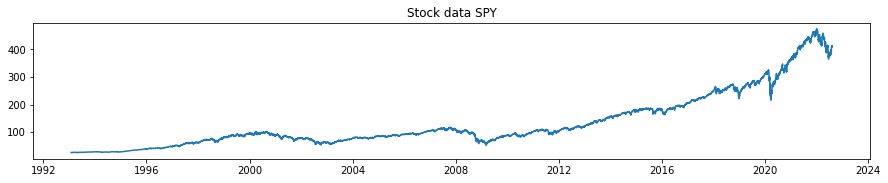

[*********************100%***********************]  1 of 1 completed
connected to yahoo


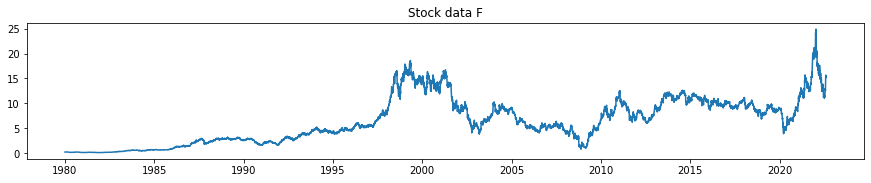

[*********************100%***********************]  1 of 1 completed
connected to yahoo


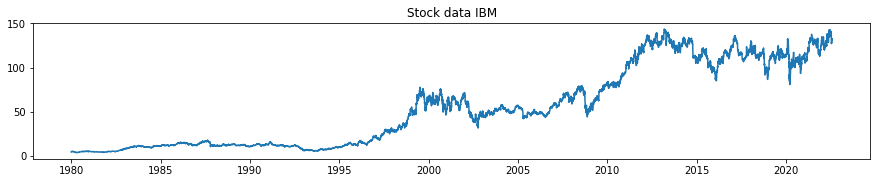

[*********************100%***********************]  1 of 1 completed
connected to yahoo


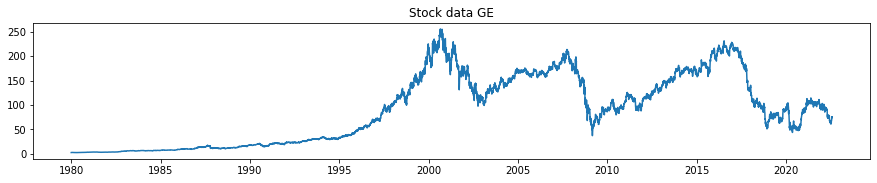

[*********************100%***********************]  1 of 1 completed
connected to yahoo


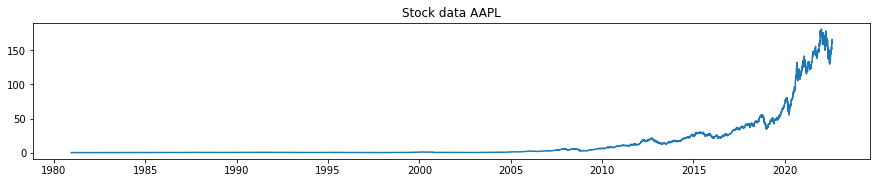

[*********************100%***********************]  1 of 1 completed
connected to yahoo


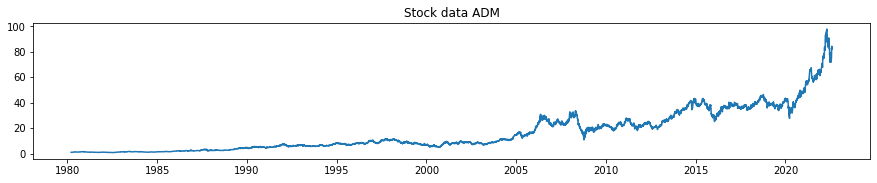

In [ ]:
for ticker in tickers:

    df = get_data(ticker)
    plot_train_data(df)
    df = compute_technical_indicators(df)
    df = compute_features(df)
    df=define_target_condition(df)

    clf = splitting_and_training(df)

    save_model(clf)
    
    # commenting out saves time during training
    #df = predict_timeseries(df, clf)
    #plot_stock_prediction(df, ticker)

# How to load trained random forest model:

In [ ]:
# load classifier, no need to initialize the loaded_rf
loaded_clf = joblib.load("./random_forest.joblib")
clf = loaded_clf

### Sources:
https://blog.quantinsti.com/decision-tree/
https://blog.quantinsti.com/parabolic-sar/
https://mljar.com/blog/save-load-random-forest/